In [4]:
import torch
import torchvision
import os
import tarfile
import torchvision.transforms as tt
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import sys
import errno

In [5]:
torch.cuda.is_available()

True

In [7]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '/media/souravsaini/Data/POP_OS/dl/pytorch/pytorch')

Using downloaded and verified file: /media/souravsaini/Data/POP_OS/dl/pytorch/pytorch/cifar10.tgz


In [12]:
with tarfile.open('/media/souravsaini/Data/POP_OS/dl/pytorch/pytorch/cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='/media/souravsaini/Data/POP_OS/dl/pytorch/pytorch')

In [15]:
data_dir = '/media/souravsaini/Data/POP_OS/dl/pytorch/pytorch/cifar10'
airplane_files = os.listdir(data_dir + "/train/airplane")
print("len=", len(airplane_files))
print(airplane_files[:5])

len= 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [17]:
dataset = ImageFolder(data_dir + "/train", transform = ToTensor())

In [18]:
img, label = dataset[0]
print(img.shape, label)
print(img)

torch.Size([3, 32, 32]) 0
tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235

we have images of 32x32 pixels and since it is a coloured image therefore we have 3 vectors for red, green and yellow 

In [19]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


in the above code the label comes out to be 0. this means that in the dataset.classes the zeroth index is the label

label=  airplane (0)


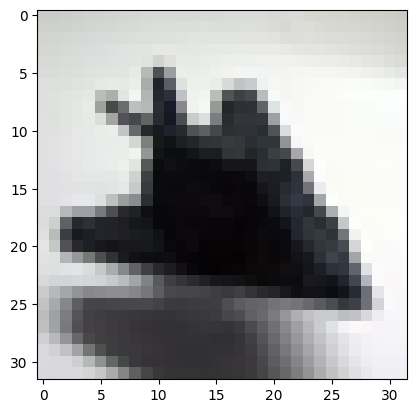

In [20]:
def show(img, label):
    print('label= ', dataset.classes[label], '('+str(label)+')')
    plt.imshow(img.permute(1,2,0))
    
show(*dataset[0])

label=  airplane (0)


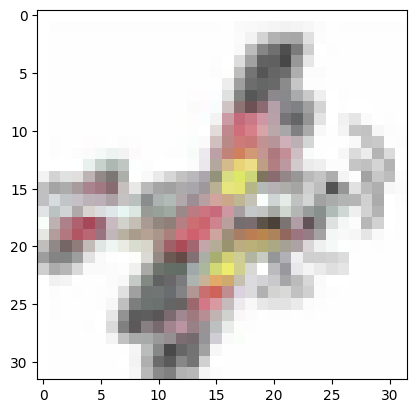

In [21]:
show(*dataset[121])

# Function to split the dataset into the validation set and the training set

In [22]:
def split(n, val_pct=0.1, seed=99):   # seed is used to generaloze the random no. generator
    # determine the size of validation set
    n_val = int(val_pct*n)
    # set the random seed (for reproducibility)
    np.random.seed(seed)
    # create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # pick first n_val indices for the validation set
    return idxs[n_val:], idxs[:n_val]

In [23]:
val_pct = 0.2
rand_seed = 42

train_indices, val_indices = split(len(dataset), val_pct, rand_seed)
print(len(train_indices), len(val_indices))

40000 10000


# Creating batches of training and validation set

In [24]:
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 100, train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset, 100, val_sampler)

we can look at the batches of images from the dataset using the make_grid method from torchvision. each time the following code is run, we get a different batch, since the smapler shuffles the indices before creating batches

In [25]:
def show(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))  # (10,10) is the figure size
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1,2,0))
        break

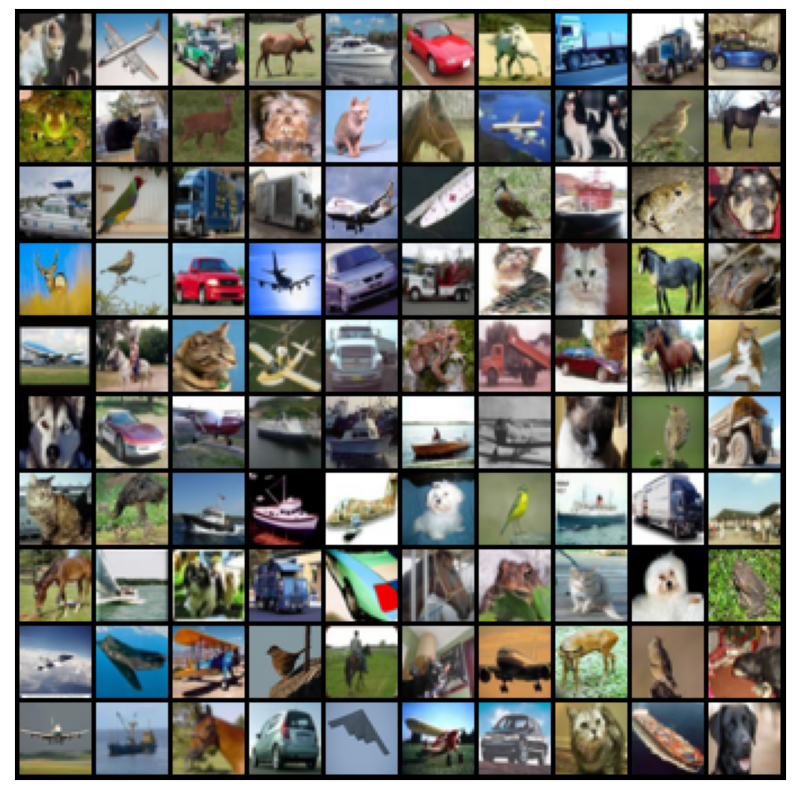

In [26]:
show(train_dl)

the above images is one of the batches of the training set

# Defining the Model (convolution Neural Network)

we will be using a convolutional neural network using the nn.Conv2d class from the Pytorch

#### 2D convolutional matrix
we start with a kernel which is simply a small matrix of weights. This kernel sildes over 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel



In [27]:
simple_model = nn.Sequential(nn.Conv2d(3,8,kernel_size=3,stride=1, padding=1), nn.MaxPool2d(2,2))

here we are creating a smaller matrix out of a larger matrix. we have made a white boundary outside the larger matrix, but we can also do it without creating the boundary. 

here kerenl_size refers to the size of sub_matrix we are using to create a smaller matrix.

stride is the no. of rows or columns by which we are shifting our kernel.

padding insures that we do not loose any pixel while creating a convolution matrix

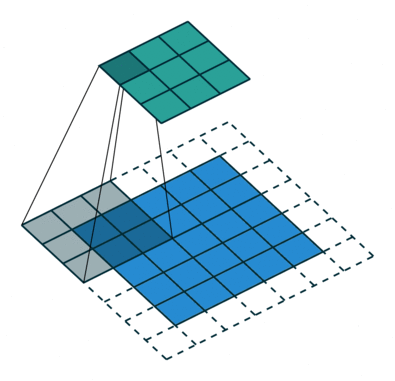

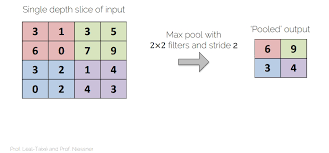

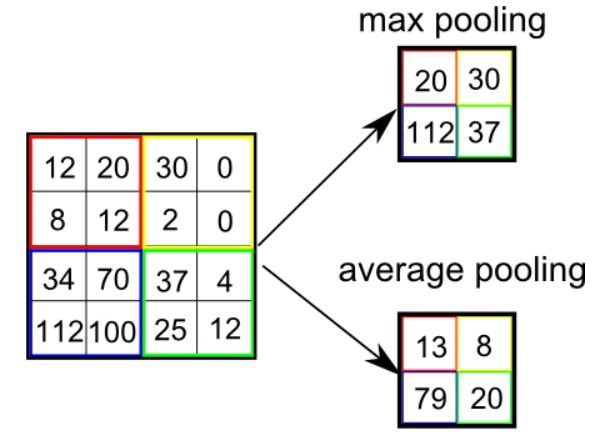

In [28]:
for images, labels in train_dl:
    print('image shape=', images.shape)
    out = simple_model(images)
    print('out shape=', out.shape)
    break

image shape= torch.Size([100, 3, 32, 32])
out shape= torch.Size([100, 8, 16, 16])


the COnv2d layer transforms a 3 channel image to a 16 channel feature map, amd the MaxPool2d layer halves the height and the width. The feature map gets smaller and smaller as we add more layers untill we are finally left with a nx1x1 feature map ( where n in the no. of channels ), which can be flattened into a vector. We can add a fully connected layer at the end to get vector of size 10 for each image.

In [29]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),  # output = Batch_size x 16 x 16 x 16
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),  # output = Batch_size x 16 x 8 x 8
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),  # output = Batch_size x 16 x 4 x 4
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),  # output = Batch_size x 16 x 2 x 2
    
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),  # output = Batch_size x 16 x 1 x 1
    
    nn.Flatten(),       # output = Batch_size x 16 
    nn.Linear(16, 10)   # output = Batch_size x 10
)

In [30]:
print(model[0].weight.shape)
print(model[9].weight.shape)
print(model[0].bias.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16, 16, 3, 3])
torch.Size([16])


In [31]:
print(model[0].weight)

Parameter containing:
tensor([[[[-0.0242,  0.0994, -0.0401],
          [ 0.1639, -0.0505, -0.0851],
          [ 0.1144, -0.0907,  0.1090]],

         [[ 0.1301, -0.0550,  0.1715],
          [-0.0506,  0.0648, -0.0286],
          [ 0.0509,  0.1069,  0.1620]],

         [[ 0.1674, -0.1467,  0.0237],
          [-0.0545, -0.0259,  0.0023],
          [-0.0109,  0.1016, -0.1503]]],


        [[[-0.0894, -0.1655, -0.0549],
          [ 0.1111,  0.0531,  0.1804],
          [-0.0508,  0.1430, -0.0596]],

         [[ 0.0235, -0.1793,  0.1565],
          [-0.1870, -0.1140, -0.0630],
          [-0.0313,  0.0184, -0.1838]],

         [[ 0.0193,  0.0959,  0.0534],
          [-0.1611, -0.0871, -0.1289],
          [-0.0830,  0.0581,  0.1063]]],


        [[[ 0.0470, -0.1336,  0.0278],
          [-0.0675,  0.0363,  0.0614],
          [ 0.1821, -0.0457, -0.1058]],

         [[-0.1785, -0.0956,  0.0892],
          [ 0.0861, -0.0581, -0.1898],
          [ 0.1662, -0.0982, -0.0479]],

         [[-0.0549,  0

In [32]:
print(model[0].bias)

Parameter containing:
tensor([-0.1014,  0.1597,  0.0077, -0.1662, -0.0997,  0.0562, -0.1011,  0.1176,
        -0.0834,  0.1626, -0.0839, -0.1578, -0.1334,  0.1258,  0.1343,  0.1813],
       requires_grad=True)


In [33]:
np.set_printoptions(suppress = True)
for images, labels in train_dl:
    print('images.shape=', images.shape)  # batch_size x rgb x 32 pixel x 32 pixel
    out = model(images)
    print('out.shape=', out.shape) # batch_size x probability of images out of 10 different classes
    print('out[0]=\n', out[0])
    print('probabilities=\n', F.softmax(out[0]))
    break

images.shape= torch.Size([100, 3, 32, 32])
out.shape= torch.Size([100, 10])
out[0]=
 tensor([-0.1130,  0.0808,  0.0989,  0.0956, -0.1393,  0.0427, -0.1693, -0.2553,
         0.1978, -0.0922], grad_fn=<SelectBackward0>)
probabilities=
 tensor([0.0907, 0.1101, 0.1121, 0.1118, 0.0884, 0.1060, 0.0858, 0.0787, 0.1238,
        0.0926], grad_fn=<SoftmaxBackward0>)


/tmp/ipykernel_8033/2521071386.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print('probabilities=\n', F.softmax(out[0]))


In [34]:
prob = F.softmax(out[0], dim=0)
print(torch.max(prob))

tensor(0.1238, grad_fn=<MaxBackward1>)


# Using GPU

In [35]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [36]:
device = get_default_device()
print(device)

cuda


In [37]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=16, out_features=10, bias=True)
)

# Training the Model

In [38]:
def loss_batch(model, loss_fn, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_fn(preds, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
        
    return loss.item(), len(xb), metric_result

In [39]:
def evaluation(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrix = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metrix = None
        if metric is not None:
            avg_metrix = np.sum(np.multiply(metrix, nums))/total
        return avg_loss, total, avg_metrix

In [40]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, opt = None, lr=None, metric=None):
    train_losses, val_losses, val_metrix = [], [], []
    
    if opt is None:
        opt = torch.optim.SGD
    opt = opt(model.parameters(), lr)
    
    for i in range(epochs):
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)
            
        model.eval()
        result = evaluation(model, loss_fn, valid_dl, metric)
        val_loss, total, val_met = result
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrix.append(val_met)
        
        if metric is None:
            print("epoch [", i+1, ',', epochs, '] , loss= ', val_loss)
        else:
            print('*Epoch [', i+1, ',', epochs, '], loss= ', val_loss, ',', metric.__name__, ',' , val_met)
            
    return train_losses, val_losses, val_metrix

In [41]:
def accuracy(outputs, lables):
    prob, preds = torch.max(outputs, dim = 1)
    return torch.sum(preds == lables).item()/len(preds)

In [35]:
val_loss, total, val_acc = evaluation(model, F.cross_entropy, val_dl, accuracy)
print("loss= ", val_loss, " accuracy= ", val_acc)

KeyboardInterrupt: 

In [34]:
for xb, yb in val_dl:
    print('xb.device=', xb.device)
    print('yb= ', yb)
    break

xb.device= cuda:0
yb=  tensor([8, 4, 0, 6, 8, 1, 2, 3, 1, 1, 5, 1, 1, 7, 8, 7, 2, 6, 4, 0, 9, 2, 8, 8,
        3, 2, 4, 5, 9, 8, 1, 1, 2, 7, 6, 6, 1, 2, 7, 8, 2, 2, 7, 2, 7, 4, 2, 3,
        9, 6, 0, 4, 8, 7, 0, 0, 6, 0, 4, 2, 2, 7, 2, 4, 4, 7, 9, 7, 9, 9, 2, 9,
        6, 9, 1, 6, 8, 6, 3, 9, 6, 9, 6, 1, 5, 0, 6, 4, 3, 7, 4, 7, 4, 4, 6, 2,
        3, 0, 9, 1], device='cuda:0')


In [14]:
opt = torch.optim.Adam
lr = 0.005
train_losses, val_losses, val_metrix = fit(10, model, F.cross_entropy, train_dl, val_dl, opt, lr, accuracy)

NameError: name 'model' is not defined

In [37]:
test_dataset = ImageFolder(data_dir + "\\test", transform = ToTensor())

label=  automobile , Prediction=  airplane


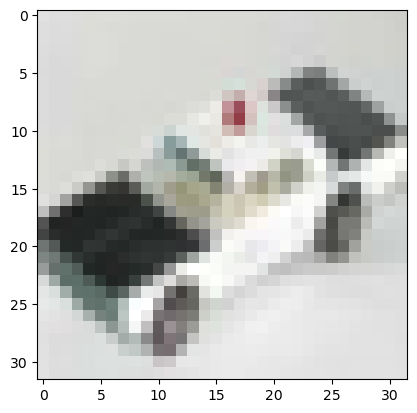

In [46]:
def predict(ing, model):
    # convert to a batch of 1
    xb = img.unsqueeze(0)
    yb = model(xb.to(device))
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

img, label = test_dataset[1186]
plt.imshow(img.permute(1, 2, 0))
print('label= ', dataset.classes[label], ', Prediction= ', predict(img, model))

In [49]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, 100), device)

test_loss, _, test_acc = evaluation(model, F.cross_entropy, test_loader, accuracy)
print("loss=", test_loss, ", Accuracy=", test_acc)

loss= 1.1705920684337616 , Accuracy= 0.5765


if the test_loss and test_acc varies a lot with val_loss and val_acc then we are having a poor validation set. We need to improve our validation set

# Saving and loading the model

this is a good idea to save the weights of the model to disk so that we can reuse the model later and avoid retraing from the scratch

if suppose we have made a new model named model2 and want the same weights to be present as were in the previous model, then we can load it by
         
         model2.load_state_dict(torch.load('model_parameters.pth'))

In [50]:
torch.save(model.state_dict(), 'model_parameters.pth')

# Increasing the accuracy of the model

1. Instead of setting aside a fraction of images from the training set for validation set, we'll simply use the test set asour validation set. This just gives a little more data to train with.

2. we will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result the mean of the data across each channel is 0 and standard deviation is 1. normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training simply by having a higher or wider range of values that others.

3. We will apply randomly chosen transformation while loading from the training dataset. Specifically we will pad each image by 4 pixels and then take a random crop of size 32x32 pixels and then flip the image horizontally with 50% probability. Since the transformation will be applied randomly and dynamically each time a particualr image is loaded the model sees slightly different images in each epoch of training which allows it generalize better.

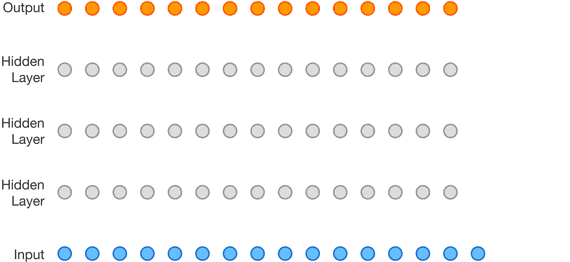

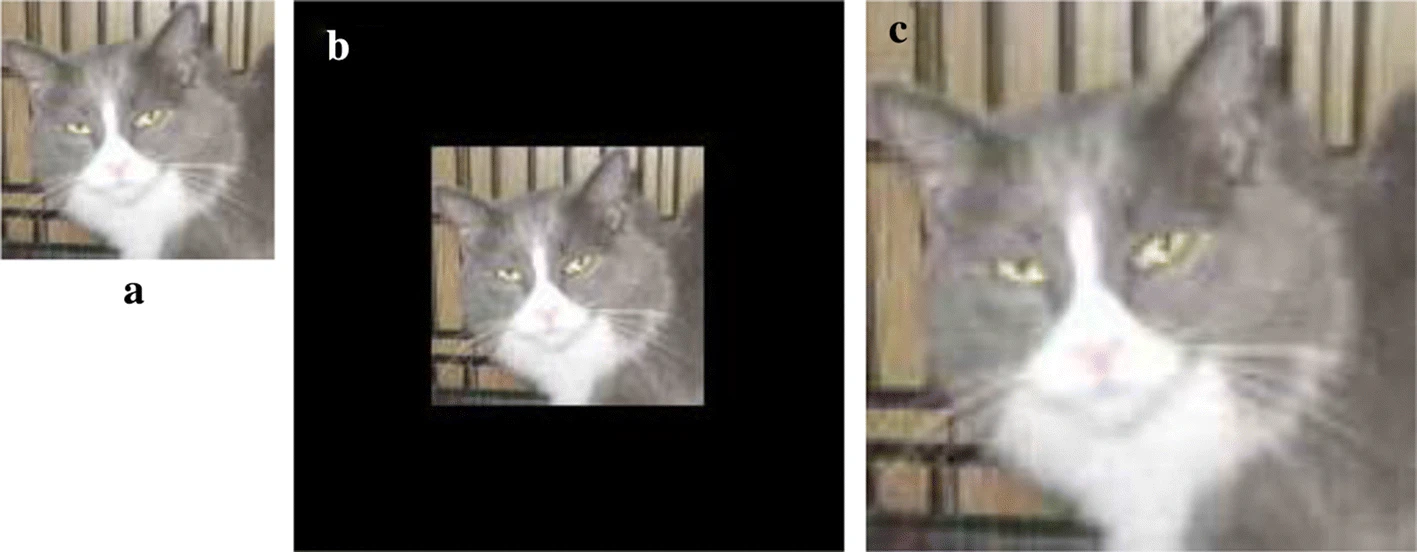

now our model will not generalize the image as now we have given the model same images in different format with object face to be on the top left, top right, with borders, without borders and so on. Like this our model will not generalize the image and try to get its characteristics

## Data transform (normalization and data augmentation)

### Normalize does the following for each channel:

image = (image - mean) / std

### if you would like to get your image back in [0,1] range, you could use,

image = ((image * std) + mean)



In [42]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [43]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
val_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [44]:
train_dl = DataLoader(train_ds, 100, shuffle=True, num_workers=8, pin_memory=True)
val_dl = DataLoader(val_ds, 100, shuffle=True, num_workers=8, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


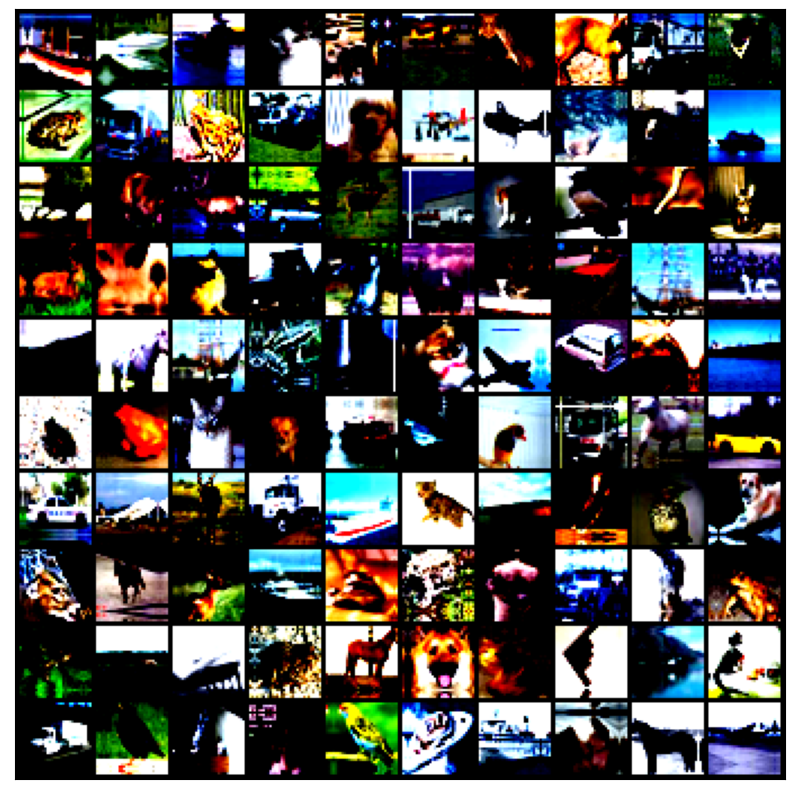

In [45]:
show(train_dl)

In [46]:
# stats = ((0.5, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
#                          tt.RandomHorizontalFlip(),
#                          tt.ToTensor(),
#                          tt.Normalize(*stats)])
# valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [47]:
# train_ds = ImageFolder(data_dir+'\\train', train_tfms)
# val_ds = ImageFolder(data_dir+'\\test', valid_tfms)
# train_dl = DataLoader(train_ds, 100, shuffle=True, num_workers=0, pin_memory=True)
# val_dl = DataLoader(val_ds, 100, shuffle=True, num_workers=0, pin_memory=True)

In [48]:
# show(train_dl)

1. num_workers=0 would make data loading execute only after training or previous process is done. Setting num_workers >0 is expected to accelerate the process more especially for the i/o and augmentation of large data. For GPU specifically, this experiment found that num_workers = 4*num_GPU had the best performance. That being said, you can also test the best num_workers for your machine. To be noted, high num_workers would have a large memory consumption overhead (ref), which is also expected, because more data copies are being processed in the memory at the same time.

2. GPU cannot access data directly from the pageable memory of the CPU. The setting, pin_memory=True can allocate the staging memory for the data on the CPU host directly and save the time of transferring data from pageable memory to staging memory (i.e., pinned memory a.k.a., page-locked memory)

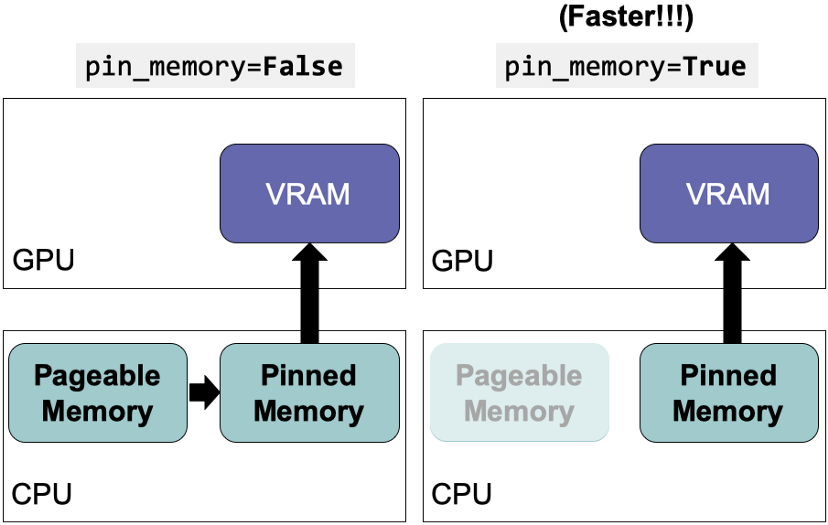

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


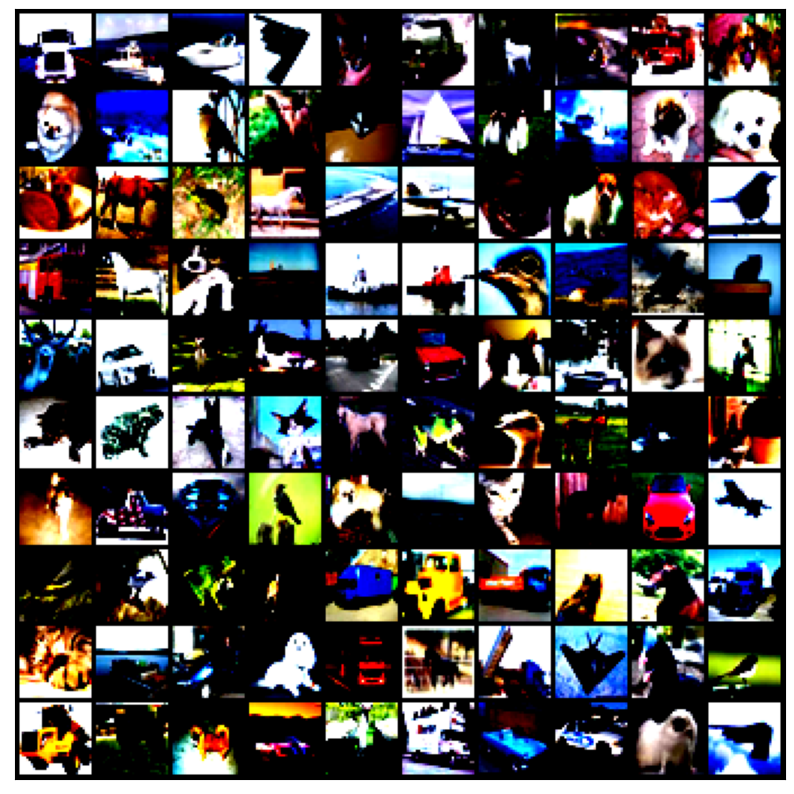

In [49]:
show(val_dl)

# Model with Residual Blocks and Batch Normalization

We'll use a significantly large model this time, called the WideResNet22 which has 22 convolutional layers. However one of the key changes to our model is the addition of the residual block to the output feature map obtained by passing the input through one or more convolutional layers

In [50]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out + x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


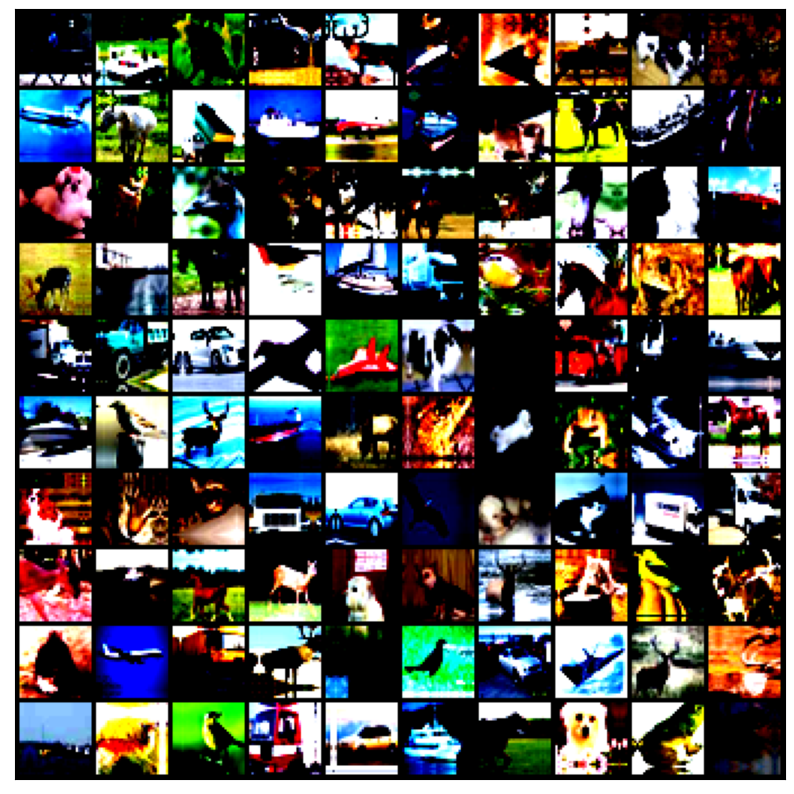

In [51]:
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
    out = simple_resnet(images)
    fig, ax = plt.subplots(figsize=(10,10))  # (10,10) is the figure size
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, 10).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


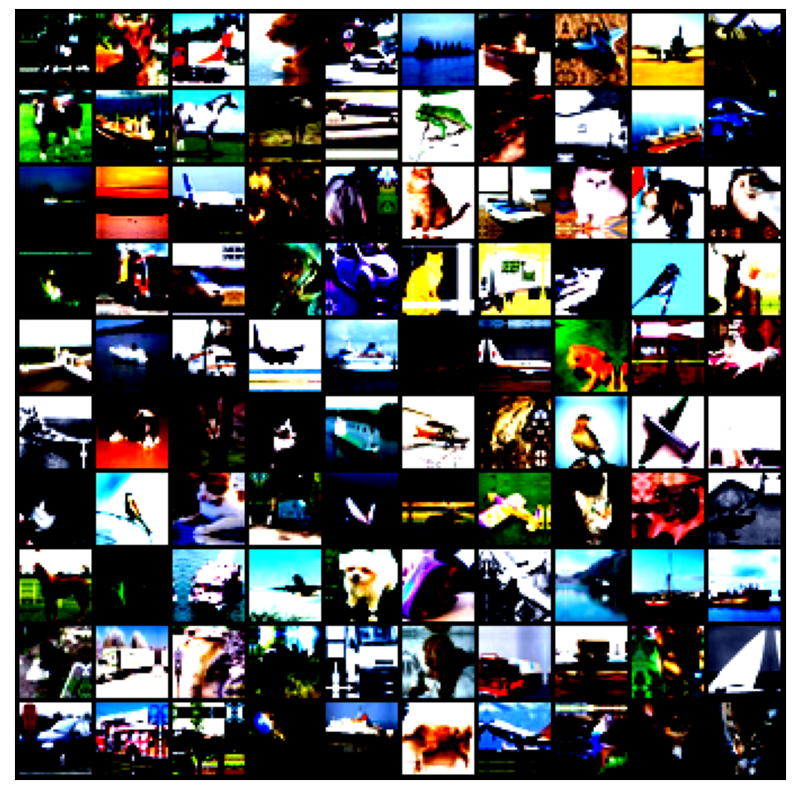

In [52]:
for images, labels in train_dl:
    fig, ax = plt.subplots(figsize=(10,10))  # (10,10) is the figure size
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, 10).permute(1,2,0))
    break

In [53]:
def conv_2d(ni, nf, stride=1, ks=3):
    # torch.nn.Conv2d(in_channels = n, out_channels = m, kernel_size = k, stride = s, padding = p)
    return nn.Conv2d(ni, nf, ks, stride, ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), nn.ReLU(inplace=True), conv_2d(ni, nf))
# nn. Sequential is a construction which is used when you want to run certain layers sequentially. 
# It makes the forward to be readable and compact.

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):   # ni = no. of input channels, nf = no. of output channels 
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni!=nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
            
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [54]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1,N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], n_channels[i+1], stride)
            
        layers += [nn.BatchNorm2d(n_channels[3]),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   Flatten(),
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.features(x)
    
def wrn_22():
    return WideResNet(3, N=3, n_classes=10, k=6)

In [55]:
model = wrn_22()

iamges.shape= torch.Size([100, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


out.shape= torch.Size([100, 10])


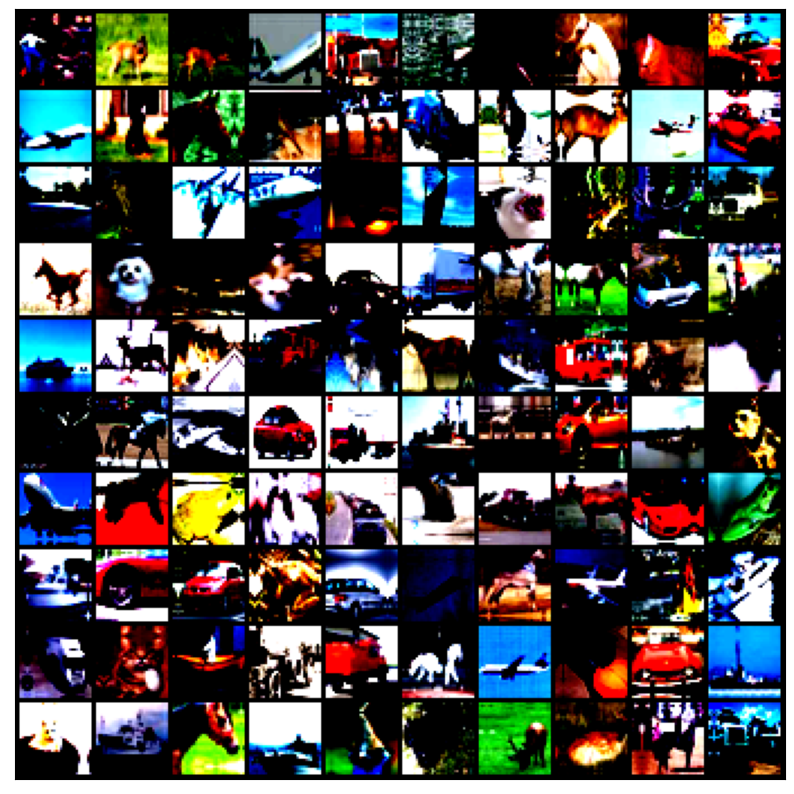

In [56]:
for images, labels in train_dl:
    print('iamges.shape=', images.shape)
    out = model(images)
    print('out.shape=', out.shape)
    fig, ax = plt.subplots(figsize=(10,10))  # (10,10) is the figure size
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, 10).permute(1,2,0))
    break
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


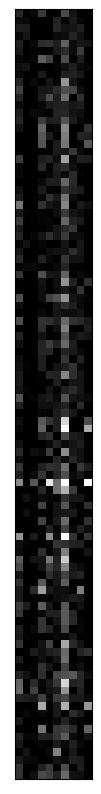

In [57]:
fig, ax = plt.subplots(figsize=(10,10))  # (10,10) is the figure size
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(out, 10).permute(1,2,0))

In [58]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

# Training the Model

In the previous models we defined a helper fxn to train the model. This time we'll use some fxns from the FastAI library, which builds on top of Pytorch and offers many utilities including a powerful and customizable training loop with learning rate scheduling

Learning rate scheduling refers to the process of dynamically changing the lr while the model is being trained. There are many stratagies for changing the lr during training and the one we'll use is called the 1-cycle policy. We start out with low lr then gradually increase it linearly to high value for about half of the training and then slowly bring it to the original value. At the end we train for few iterations with a very low lr

The statement learner.clip = 0.1 is used to perform gradient clipping, i.e. it limit the values of the gradient to the range [-1,1], thus preventing the undesirable change in the parameters(weights and biases) due to large gradient values

FastAI also provides a helpful lr finder which tries a range of learning rates and helps you select a good lr by looking at the graph of loss vs lr

In [59]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [60]:
opt = torch.optim.Adam
lr = 0.005
train_losses, val_losses, val_metrix = fit(10, model, F.cross_entropy, train_dl, val_dl, opt, lr, accuracy)

*Epoch [ 1 , 10 ], loss=  1.6882951211929322 , accuracy , 0.394
*Epoch [ 2 , 10 ], loss=  1.2069179600477218 , accuracy , 0.5814
*Epoch [ 3 , 10 ], loss=  1.0292438387870788 , accuracy , 0.6388
*Epoch [ 4 , 10 ], loss=  0.7105048966407775 , accuracy , 0.7506
*Epoch [ 5 , 10 ], loss=  0.6068137270212174 , accuracy , 0.7926
*Epoch [ 6 , 10 ], loss=  0.4961609137058258 , accuracy , 0.8305
*Epoch [ 7 , 10 ], loss=  0.4815614174306393 , accuracy , 0.8358
*Epoch [ 8 , 10 ], loss=  0.5177150067687034 , accuracy , 0.8291
*Epoch [ 9 , 10 ], loss=  0.42360229045152664 , accuracy , 0.8565
*Epoch [ 10 , 10 ], loss=  0.4118623669445515 , accuracy , 0.8639


In [61]:
model = model.to(device)
print(train_dl.device)

cuda


In [39]:
opt = torch.optim.Adam
lr = 0.003
train_losses, val_losses, val_metrix = fit(10, model, F.cross_entropy, train_dl, val_dl, opt, lr, accuracy)

*Epoch [ 1 , 10 ], loss=  0.32326056286692617 , accuracy , 0.891
*Epoch [ 2 , 10 ], loss=  0.3255184130370617 , accuracy , 0.8898
*Epoch [ 3 , 10 ], loss=  0.35292293414473536 , accuracy , 0.89
*Epoch [ 4 , 10 ], loss=  0.34412993758916854 , accuracy , 0.8941
*Epoch [ 5 , 10 ], loss=  0.3446378556638956 , accuracy , 0.8902
*Epoch [ 6 , 10 ], loss=  0.31273107990622523 , accuracy , 0.9021
*Epoch [ 7 , 10 ], loss=  0.338848195374012 , accuracy , 0.8982
*Epoch [ 8 , 10 ], loss=  0.32225880555808545 , accuracy , 0.9022
*Epoch [ 9 , 10 ], loss=  0.31802383087575437 , accuracy , 0.907
*Epoch [ 10 , 10 ], loss=  0.31688864625990393 , accuracy , 0.9075
